# Exploratory Data Analysis (EDA) of the **CBIS-DDSM** Dataset
In this section, we conduct an exploratory data analysis of the CBIS-DDSM Case and DICOM datasets prepared in prior sections. The purpose of this EDA is four-fold:
1. Discover the relationships among the variables.
2. Understand the nature and degree to which the variables pertain to the diagnosis of breast cancer.
3. Identify errors, outliers, and anomalies in the data before the modeling stage.
4. Assess image quality for image data pre-processing.

## The Datasets
The scope of this EDA includes the following datasets:
- Case Datasets: Calcification and mass datasets containing patient, abnormality, BI-RADS assessment, image view, breast density, subtlety, and pathology (diagnosis) information.
- DICOM Dataset: Contains image properties, such as image size, shape, bit-depth, aspect ratio, and photometric interpretation.
- DICOM Images: The mammography, ROI masks, and cropped images in DICOM format.

### Case Dataset Dictionary

| #  | Variable             | Type        | Description                                                                                                                  | Validity                                   |
|----|----------------------|-------------|------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------|
| 1  | patient_id           | Nominal     | Unique identifier for each patient.                                                                                          | String of format "P_00000'                 |
| 2  | breast_density       | Discrete    | BI-RADS overall assessment of the volume of attenuating tissues in the   breast.                                             | Integer range [1,4]                        |
| 3  | left_or_right_breast | Nominal     | Which breast was imaged.                                                                                                     | RIGHT or LEFT                              |
| 4  | image_view           | Dichotomous | Either craniocaudal or mediolateral oblique view.                                                                            | CC or MLO                                  |
| 5  | abnormality_id       | Discrete    | Number of abnormality for the patient.                                                                                       | Integer                                    |
| 6  | abnormality_type     | Dichotomous | BI-RADS category of the abnormality.                                                                                         | calcification or mass                      |
| 7  | calc_type            | Nominal     | Characterization of the type of calcification (where applicable)                                                             | See appendix                               |
| 8  | calc_distribution    | Nominal     | The arrangement of the calcifications inside the breast and, relative to   the probability of malignancy. (where applicable) | See appendix                               |
| 9  | assessment           | Discrete    | Overall BI-RADS assessment of the mammography                                                                                | Integer range [0,6]                        |
| 10 | pathology            | Nominal     | Determination of the malignancy of the case.                                                                                 | MALIGNANT, BENIGN, BENIGN_WITHOUT_CALLBACK |
| 11 | subtlety             | Discrete    | Degree of diagnostic difficulty                                                                                              | Integer range [1,5]                        |
| 12 | fileset              | Nominal     | Indicates training or test set.                                                                                              | train or test                              |
| 13 | mass_shape           | Nominal     | Shape of the mass                                                                                                            | See appendix                               |
| 14 | mass_margins         | Nominal     | Feature that separates the mass from the adjacent breast parenchyma.                                                         | See appendix                               |
| 15 | case_id              | Nominal     | Unique identifier for the case.                                                                                              | String                                     |
| 16 | cancer               | Dichotomous | Indicates whether the cancer is diagnosed.                                                                                   | True or False                              |

### DICOM Dataset Dictionary
| #  | Variable                   | Type        | Description                                                               |
|----|----------------------------|-------------|---------------------------------------------------------------------------|
| 1  | series_uid                 | Nominal     | Unique identifier for a series of images.                                 |
| 2  | filepath                   | Nominal     | The path to the image.                                                    |
| 3  | patient_id                 | Nominal     | Unique identifier for each patient.                                       |
| 4  | side                       | Nominal     | Which breast was imaged.                                                  |
| 5  | image_view                 | Dichotomous | Either craniocaudal or mediolateral oblique view.                         |
| 6  | photometric_interpretation | Nominal     | Intended interpretation of the pixel data.                                |
| 7  | samples_per_pixel          | Discrete    | Number of samples (planes) in this image.                                 |
| 8  | height                     | Discrete    | Number of rows in the image.                                              |
| 9  | width                      | Discrete    | Number of columns in the image.                                           |
| 10 | size                       | Discrete    | Number of pixels in the image.                                            |
| 11 | aspect_ratio               | Continuous  | Ratio of vertical and horizontal size.                                    |
| 12 | bits                       | Discrete    | Number of bits stored for each pixel sample.                              |
| 13 | smallest_image_pixel       | Discrete    | The minimum actual pixel value encountered in the image.                  |
| 14 | largest_image_pixel        | Discrete    | The maximum actual pixel value encountered in the image.                  |
| 15 | image_pixel_range          | Discrete    | Difference between largest and smallest image pixel.                      |
| 16 | brisque                    | Continuous  | BRISQUE score indicating overall quality of the image.                    |
| 17 | series_description         | Nominal     | Whether the series contains full mammography, ROI mask or cropped images. |


## Guiding Questions
> “Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question, which can always be made precise.” — John Tukey

Here, we'll put forward a set of questions to motivate and guide the discovery process.

**General Questions**
1. Density is considered a potential signal of pathology. How does density relate to BI-RADS assessment and pathology in the CBIS-DDSM dataset?
2. Are abnormalities considered more subtle in dense breasts? 
4. Is breast density determinative of abnormality type, to some degree?
5. Are masses more or less subtle than calcification abnormalities?
7. To what degree are the BI-RADS assessments and pathology in agreement?
8. Does subtlety affect the agreement between BI-RADS assessment and pathology?

**Calcification Cases**
1. Which calcification types are most malignant?
2. How do calcification type and distribution relate to pathology?
3. What does the calcification distribution imply about a diagnosis?
4. To what degree does calcification distribution relate to breast density? 
5. Are certain calcification types more or less subtle than others?
6. To what degree are subtlety and calcification distribution related?

**Mass Cases**
1. How does mass shape relate to pathology?
2. To what degree do mass shape and mass margins affect a BI-RADS assessment? Pathology?
3. What is the relationship between subtlety and mass shape? Mass margins?
4. Do the data support a relationship between breast density and mass shape? mass margins?

**Image Properties**
1. What is the overall quality of the images in the dataset?
2. What is the distribution of the image sizes in terms of height and width?
3. Is bit-depth consistent across all images? Full mammograms? ROI Masks?
4. Is photometric interpretation consistent across all full mammogram images? ROI masks?
5. To what degree are image and ROI mask sizes in agreement?

**Images**
1. To what degree are artifacts (marks and texts) extant in the imaging?
2. How would image brightness and contrast be characterized in the dataset?
3. Is visual intra-class dissimilarity and inter-class similarity a factor among benign calcifications, benign masses, malignant calcifications, and malignant masses?


## Exploratory Data Analysis Plan
The EDA will be conducted in six stages:

| Stage | Dataset        | Analysis     | Focus                                                                                                  |
|-------|----------------|--------------|--------------------------------------------------------------------------------------------------------|
| 1     | Case           | Univariate   | Explore descriptive statistics for each variable in the datasets   separately.                         |
| 2     | Case           | Bivariate    | Analyze pairwise relationships between variables.                                                      |
| 3     | Case           | Multivariate | Evaluate the relationships among multiple variables (more than two) and   patterns.                    |
| 4     | DICOM Metadata | Quality      | Assessment of overall quality of images.                                                               |
| 5     | DICOM Metadata | Structure    | Analyze the image sizes, shape and pixel values.                                                       |
| 6     | DICOM Images   | Visual       | Conduct visual analysis of various abnormalities, densities, and   diagnoses.                          |

## Preliminaries
The section has the following python package dependencies:
- **Pandas**: Tabular data processing and analysis
- **Numpy**: Numerical processing
- **Matplotlib** and **Seaborn**: Data visualization
- **Scipy**: Statistical analysis
- **StudioAI**: Data visualization and statistical analysis 

In [11]:
import sys
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings
warnings.filterwarnings("ignore")

In [12]:
import pandas as pd
from scipy import stats
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from studioai.stats.inferential.cramersv import CramersVAnalysis
from studioai.stats.inferential.kendallstau import KendallsTauAnalysis

from bcd.data.dataset.case import CaseDataset
from bcd.data.dataset.dicom import DicomDataset

sns.set_style('whitegrid')
sns.set_palette("Blues_r")

In [13]:
CASE_FP = "data/clean/cases.csv"
CALC_FP = "data/clean/calc_cases.csv"
MASS_FP = "data/clean/mass_cases.csv"
DICOM_FP = "data/staged/dicom.csv"

In [20]:
cases = CaseDataset(filepath=CASE_FP)
calc = CaseDataset(filepath=CALC_FP)
mass = CaseDataset(filepath=MASS_FP)
df_cases = cases.as_df()

## Case Data Univariate Analysis
Let's get an overall sense of the data

In [15]:
summary = cases.summary()
summary

,Summary
Patients,1566
Cases,3566
Calcification Cases,1872
Calcification Cases - Benign,1199
Calcification Cases - Malignant,673
Mass Cases,1694
Mass Cases - Benign,910
Mass Cases - Malignant,784


In [16]:
st = summary.T
pct_calc = round(st['Calcification Cases'] / st['Cases'] * 100,2).values[0]
pct_mass = round(st['Mass Cases'] / st['Cases'] * 100,2).values[0]
pct_calc_mal = round(st['Calcification Cases - Malignant'] / st['Calcification Cases'] * 100,2).values[0]
pct_calc_bn = round(st['Calcification Cases - Benign'] / st['Calcification Cases'] * 100,2).values[0]
pct_mass_mal = round(st['Mass Cases - Malignant'] / st['Mass Cases'] * 100,2).values[0]
pct_mass_bn = round(st['Mass Cases - Benign'] / st['Mass Cases'] * 100,2).values[0]
cases_per_patient = round(st['Cases'] / st['Patients'],2).values[0]
msg = f"Key Observations\n"
msg += f"1.\tThe number of patients, {st['Patients'].values[0]} comports with the TCIA data description.\n"
msg += f"2.\tWe have {st['Cases'].values[0]} cases, {pct_calc}% are calcification cases and {pct_mass}% are mass cases.\n"
msg += f"3.\tOf the calcification cases, {pct_calc_bn}% are benign, {pct_calc_mal} or malignant.\n"
msg += f"4.\tOf the mass cases, {pct_mass_bn}% are benign, {pct_mass_mal} or malignant.\n"
msg += f"5\tOn average we have approximately {cases_per_patient} cases per patient."
print(msg)

Key Observations
1.	The number of patients, 1566 comports with the TCIA data description.
2.	We have 3566 cases, 52.5% are calcification cases and 47.5% are mass cases.
3.	Of the calcification cases, 64.05% are benign, 35.95 or malignant.
4.	Of the mass cases, 53.72% are benign, 46.28 or malignant.
5	On average we have approximately 2.28 cases per patient.



Let's take a look at the calcification and mass data.

In [17]:
calc.head()
mass.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc_type,calc_distribution,assessment,pathology,subtlety,fileset,case_id,cancer
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,train,P_00005_RIGHT_calcification_CC_1,True
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,train,P_00005_RIGHT_calcification_MLO_1,True
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,train,P_00007_LEFT_calcification_CC_1,False
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,train,P_00007_LEFT_calcification_MLO_1,False
4,P_00008,1,LEFT,CC,1,calcification,AMORPHOUS,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,train,P_00008_LEFT_calcification_CC_1,False


,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,assessment,pathology,subtlety,fileset,mass_shape,mass_margins,case_id,cancer
0,P_00001,3,LEFT,CC,1,mass,4,MALIGNANT,4,train,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,P_00001_LEFT_mass_CC_1,True
1,P_00001,3,LEFT,MLO,1,mass,4,MALIGNANT,4,train,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,P_00001_LEFT_mass_MLO_1,True
2,P_00004,3,LEFT,CC,1,mass,4,BENIGN,3,train,ARCHITECTURAL_DISTORTION,ILL_DEFINED,P_00004_LEFT_mass_CC_1,False
3,P_00004,3,LEFT,MLO,1,mass,4,BENIGN,3,train,ARCHITECTURAL_DISTORTION,ILL_DEFINED,P_00004_LEFT_mass_MLO_1,False
4,P_00004,3,RIGHT,MLO,1,mass,4,BENIGN,5,train,OVAL,CIRCUMSCRIBED,P_00004_RIGHT_mass_MLO_1,False


### Breast Density
Radiologists classify breast density using a 4-level density scale {cite}BreastImagingReporting:

1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

According to the American College of Radiology™️, breast density in the U.S.:

- 10% of women have almost entirely fatty breasts,
- 10% have extremely dense breasts,
- 40% of women have scattered areas of fibroglandular density
- 40% have heterogeneously dense breasts

{figure}
:name: density_ref
Breast Density Categories {cite}`WHATAREDENSE`

In [22]:
d1 = np.repeat([1], int(df_cases.shape[0]*.1))
d2 = np.repeat([2], int(df_cases.shape[0]*.4))
d3 = np.repeat([3], int(df_cases.shape[0]*.4))
d4 = np.repeat([4], int(df_cases.shape[0]*.1))
d = np.append(arr=d1,values=d2)
d = np.append(arr=d,values=d3)
d = np.append(arr=d,values=d4)
d = {"Breast Density": d, "Sample": "U.S."}
usd = pd.DataFrame(data=d)
density = df_cases['breast_density'].to_frame()
density.rename(columns={'breast_density': 'Breast Density'}, inplace=True)
density['Sample'] = 'CBIS-DDSM'
density = pd.concat([density, usd], axis=0).reset_index()

The following exhibits the counts by breast density category in the CBIS-DDSM dataset vis-a-vis a sample from the US of the same size.

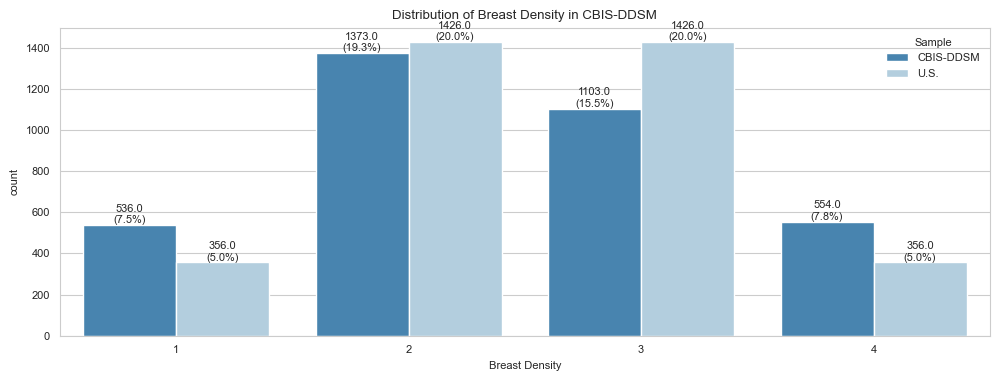

In [23]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(data=density,x='Breast Density', hue="Sample", ax=ax, title ="Distribution of Breast Density in CBIS-DDSM", dodge=True)

Interesting. The distribution of breast density in the dataset models pretty closely the distribution of breast density in the United States. 

### Left or Right Side

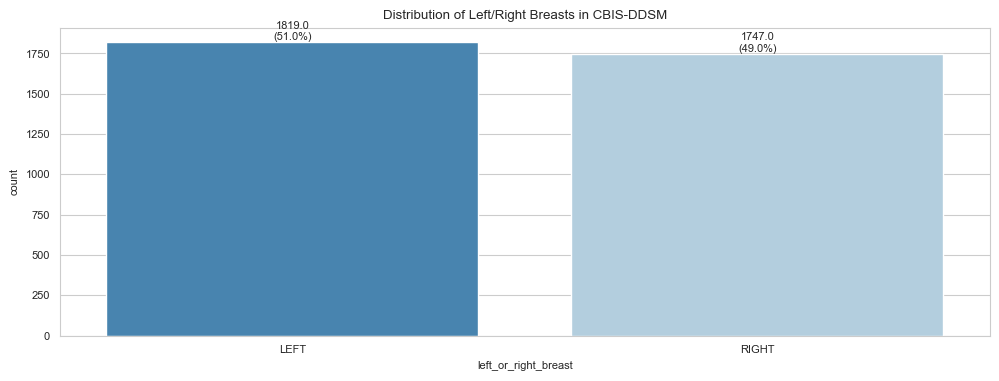

In [24]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='left_or_right_breast', ax=ax, title ="Distribution of Left/Right Breasts in CBIS-DDSM")

The dataset is approximately balanced with respect to left or right breasts.

### Image View
CBIS-DDSM contains digital mammography images in two different views: cranial caudal (CC) and mediolateral oblique (MLO). The CC view is taken from above the breast; whereas, the MLO view is taken from the center of the breast outward. 

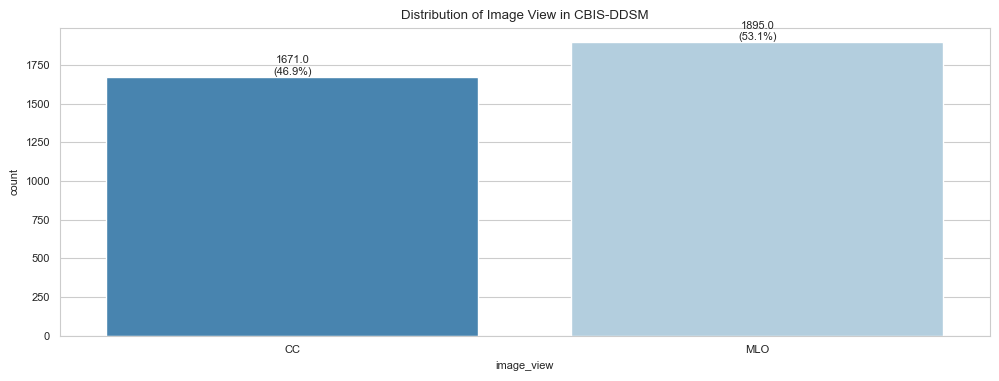

In [25]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='image_view', ax=ax, title ="Distribution of Image View in CBIS-DDSM")

Slightly greater number of MLO views; however, the dataset has a reasonable balance of image views.

### Abnormality Id
The abnormality id is a sequence number assigned to each abnormality for a patient. 

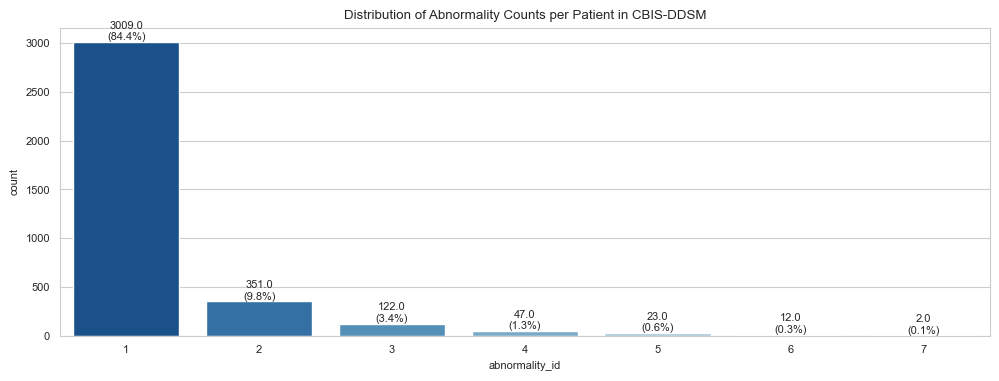

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_id', ax=ax, title ="Distribution of Abnormality Counts per Patient in CBIS-DDSM")

As indicated above, the vast majority of patients present with a single abnormality; although, a considerable number have two or more.

### Abnormality Type
CBIS-DDSM contains calcification and mass cases. 

Calcifications, common on mammograms, especially after age 50, are calcium deposits within the breast tissue. Typically benign, calcifications show up as either macrocalcifications or microcalcifications. Macrocalcifications appear as large white dots or dashes which are almost always noncancerous, requiring no further testing or follow-up. Microcalcifications show up as fine, white specks, similar to grains of salt. Usually noncancerous, but certain patterns can be an early sign of cancer.

Masses are also common, particularly among women of reproductive age. For the 25% of women affected by breast disease in their lifetime, the vast majority will present initially with a new breast mass in the primary care setting. Breast masses have a wide range of causes, from physiological adenosis to highly aggressive malignancy.  

As shown below, the dataset contains a balance of calcification and mass cases.

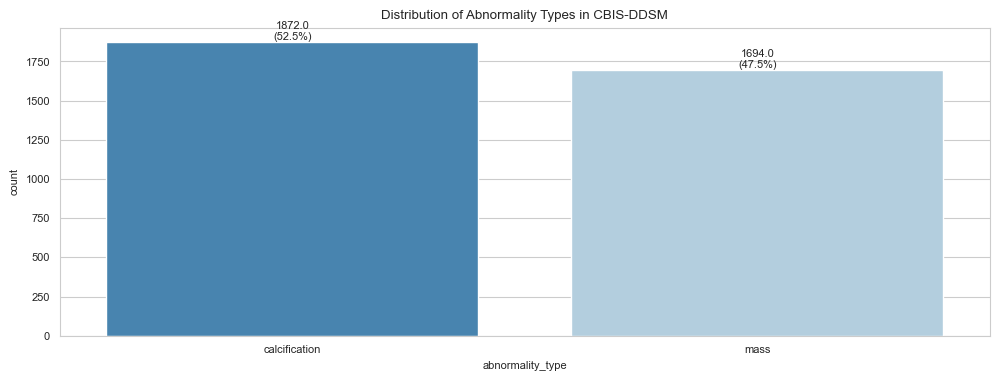

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_type', ax=ax, title ="Distribution of Abnormality Types in CBIS-DDSM")

### Subtlety
Subtlety is a measure of the degree to which a particular case is difficult to diagnose. Values range from 1 (highly subtle) to 5 (obvious).

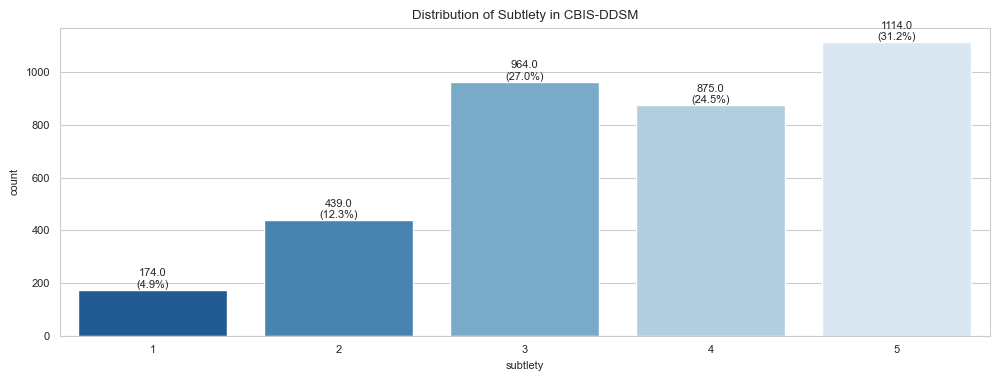

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety in CBIS-DDSM")

### BI-RADS Assessment
A BI-RADS assessment an overall assessment of the imaging and has size categories:

| Category | Definition                                                                                                                                                         |
|----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0        | Means the findings are unclear. The radiologist will need more images to   determine a score                                                                       |
| 1        | Means the findings are negative and the breast tissue appears normal. No   masses, calcifications, asymmetry or other abnormalities have been   found.             |
| 2        | Means the findings are benign, which is also negative for cancer. While a   mass, calcification or other abnormality may have been detected, it’s not   cancerous. |
| 3        | Means the findings are probably benign. While a mass, calcification or   other abnormality may have been found, it’s most likely not cancerous.                    |
| 4        | Means cancer is suspected. There are four subcategories that relate to   the probability of a malignancy: 4A (2-10%) 4B (10-50%) 4C (50-95%)                       |
| 5        | Means cancer is highly suspected. Findings have a 95% chance or higher of   being cancerous.                                                                       |
| 6        | Cancer was previously diagnosed using a biopsy.                                                                                                                    |

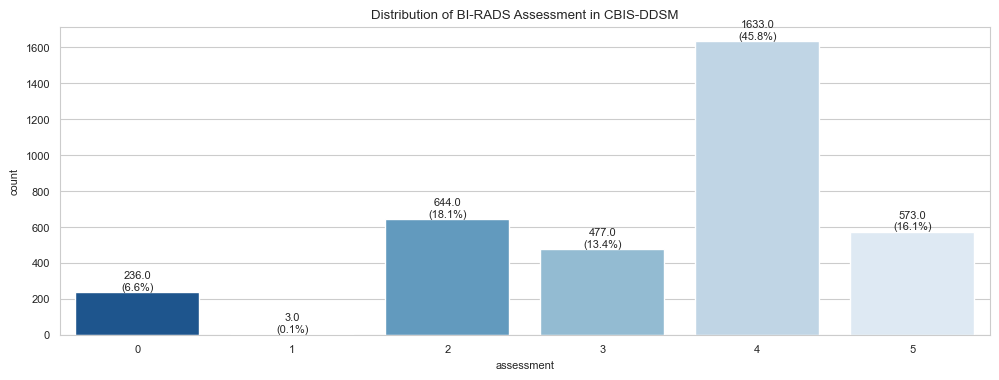

In [30]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='assessment', ax=ax, title ="Distribution of BI-RADS Assessment in CBIS-DDSM")

### Calcification Type
Calcification type describes the morphology of a case and is the most important factor in the differentiation between benign and malignant cases. There are over 40 different categories of calc_type in the dataset; yet, the some of the main categories are:

| #  | Morphology            |                                                                                                                | Assessment     |
|----|-----------------------|----------------------------------------------------------------------------------------------------------------|----------------|
| 1  | Amorphous             | Indistinct calcifications, without clearly defined shape, small and/or   hazy in appearance                    | BI-RADS 4B     |
| 2  | Coarse Heterogeneous  | Irregular, conspicuous calcifications, typically larger than 0.5 mm.                                           | BI-RADS 3      |
| 3  | Dystrophic            | Irregular, 'lava-shaped', larger than 0.5 mm, which develop 3-5 years   after treatment in about 30% of women. | BI-RADS 1 or 2 |
| 4  | Eggshell              | Very thin benign calcifications that appear as calcium                                                         | BI-RADS 1 or 2 |
| 5  | Fine Linear Branching | Thin linear or curvilinear irregular.                                                                          | BI-RADS 4B     |
| 6  | Large Rod-like        | Benign calcifications that form continuous rods that may occassionally be   branching.                         | BI-RADS 1 or 2 |
| 7  | Lucent-Centered       | Round or oval calcifications, typically result of fat necrosis, or   calcified debris in ducts                 | BI-RADS 1 or 2 |
| 8  | Milk of Calcium       | Benign sedimented calcifications in macro or microcysts.                                                       | BI-RADS 1 or 2 |
| 9  | Pleomorphic           | Calcifications varying in size and shape, more conspicuous than amorphic   calcifications.                     | BI-RADS 4B     |
| 10 | Punctate              | Round calcifications 0.5-1 mm in size.                                                                         | BI-RADS 2,3,4  |
| 11 | Skin                  | Skin calcifications, usually lucent-centered deposits                                                          | BI-RADS 1 or 2 |
| 12 | Vascular              | Linear or form parallel tracks, usually associated with blood vessels.                                         | BI-RADS 1 or 2 |



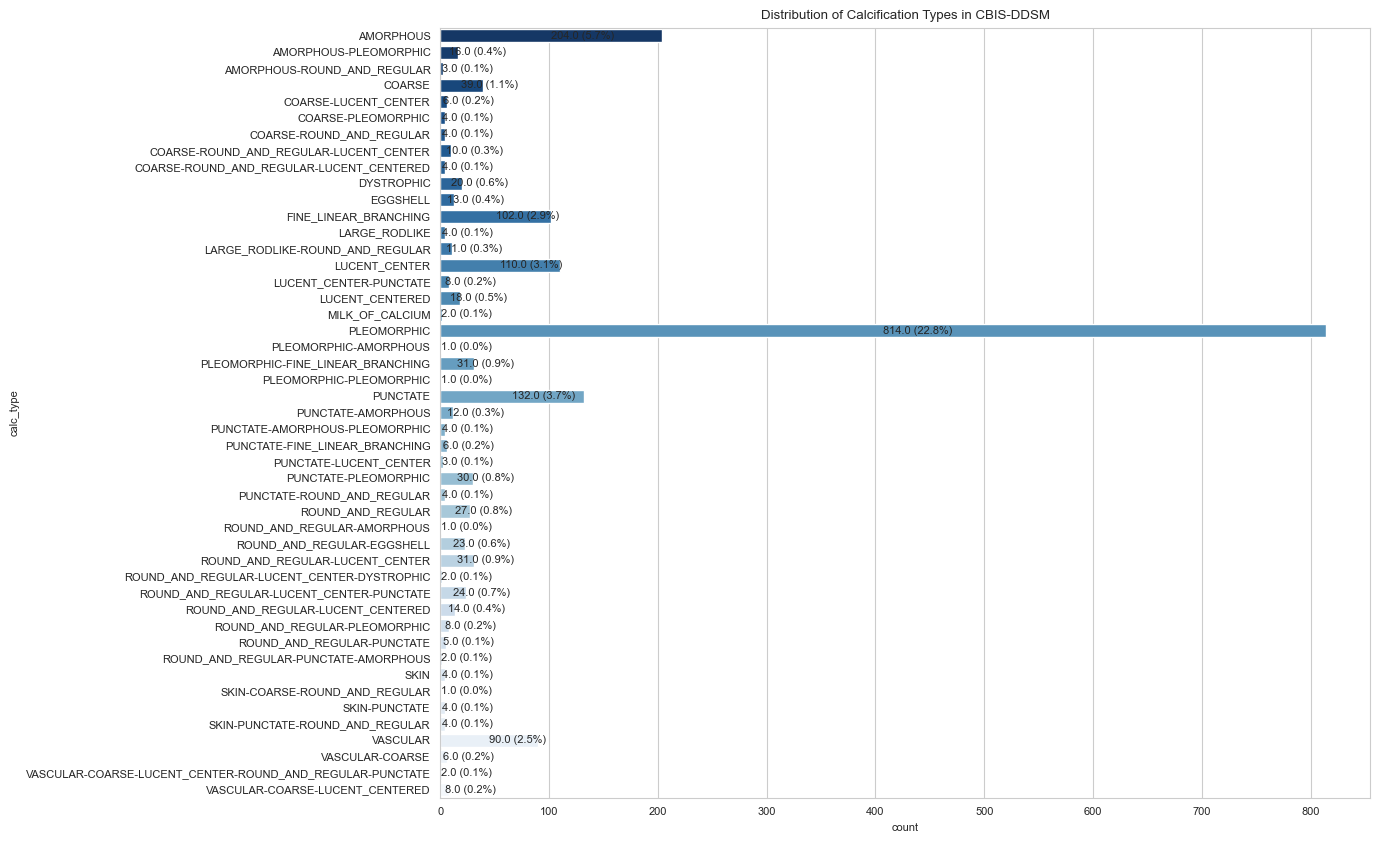

In [33]:
fig, ax = plt.subplots(figsize=(12,10))
cases.plot.countplot(y='calc_type', ax=ax, title ="Distribution of Calcification Types in CBIS-DDSM")

The vast majority of calcification types are pleomorphic, amorphous, and lucent-centered.

### Calcification Distribution
Calcification distribution refers to the arrangement of the calcifications inside the breast. BI-RADS describes the following categories of calcification distribution:
1. Diffuse or Scattered: Calcifications throughout the whole breast.
2. Regional: Scattered in a larger volume (> 2 cc) of breast tissue and not in the expected ductal distribution.
3. Clustered: Groups of at least 5 calcifications in a small volume of tissue
4. Segmental: Calcium deposits appear in ducts or branches of a segment or lobe.

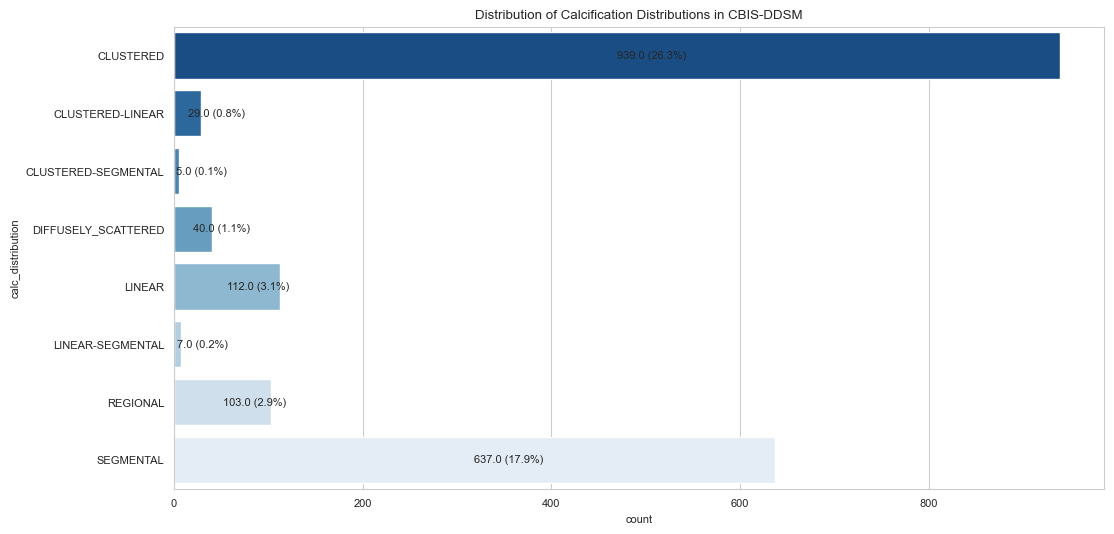

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
cases.plot.countplot(y='calc_distribution', ax=ax, title ="Distribution of Calcification Distributions in CBIS-DDSM")

### Mass Shape
The BI-RADS lexicon defines four mass shapes:
1. Round
2. Oval
3. Lobulated
4. Irregular

The following mass shapes are represented in the CBIS-DDSM.

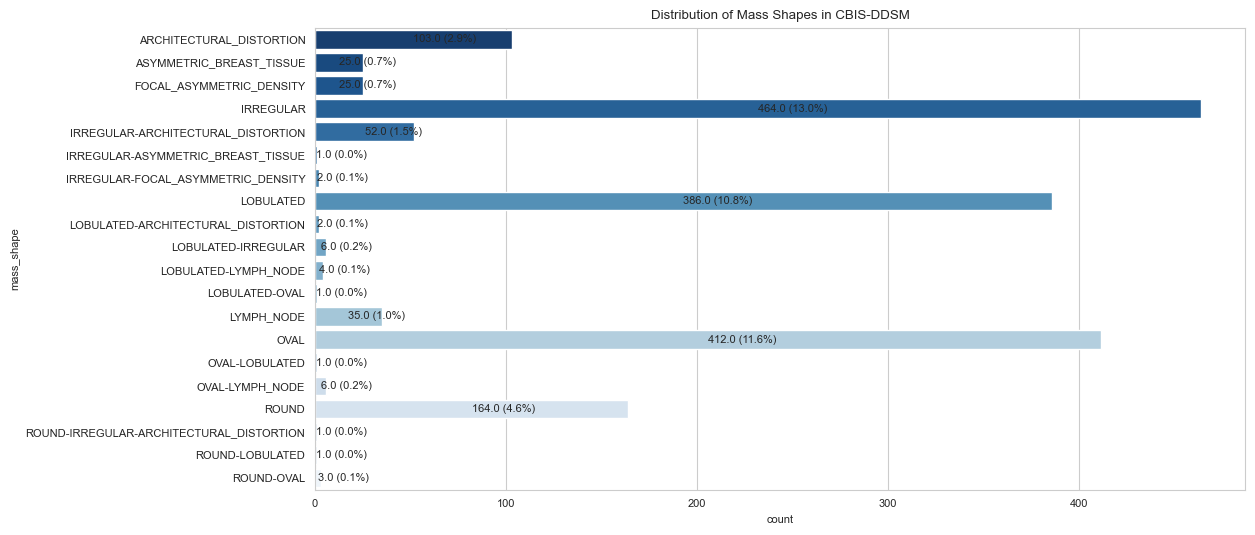

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
cases.plot.countplot(y='mass_shape', ax=ax, title ="Distribution of Mass Shapes in CBIS-DDSM")

Most mass cases have lobulated, irregular, oval or round shapes.

### Mass Margins
A feature that separates the mass from the adjacent breast parenchyma. Mass margins can be:
1. Circumscribed: Low probability of malignancy.
2. Obscured: Undetermined likelihood of malignancy.
3. Spiculated: Higher likelihood of malignancy.
4. Microlobulated: Suspicious for breast carcinoma: 
5. Ill-Defined: Also called 'indistinct'. Generally suspicious of malignancy.     


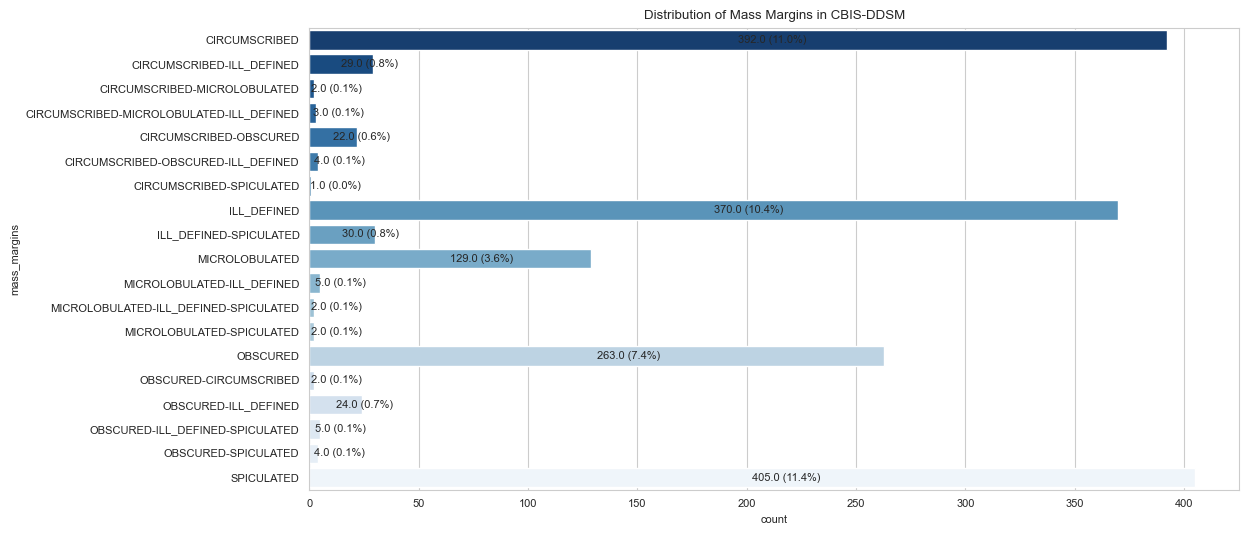

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
cases.plot.countplot(y='mass_margins', ax=ax, title ="Distribution of Mass Margins in CBIS-DDSM")

Circumscribed, ill-defined, obscured and microlobulated mass margins are most frequently observed in this dataset.

### Pathology
The dataset distinguishes three outcomes: malignant, benign, and benign without callback. The latter indicates that the region may be suspicious, and should be monitored, but no further investigation is required.

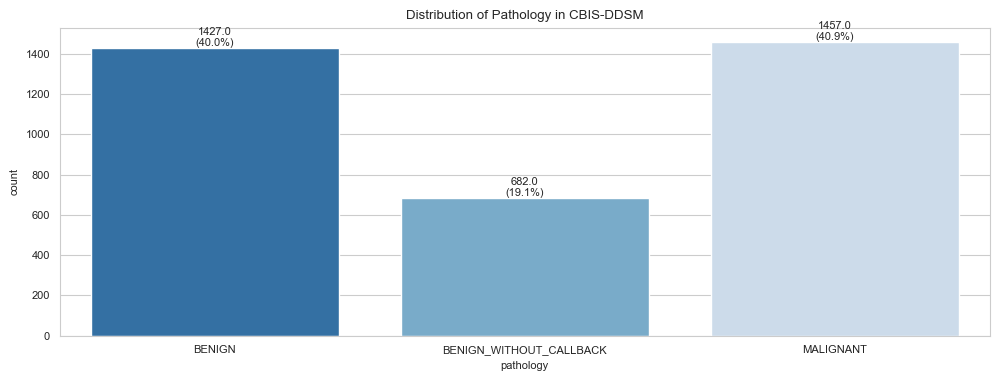

In [28]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology in CBIS-DDSM")

The majority of cases are benign; although, benign without callback represents a considerable proportion of the cases. 

### Cancer
Here, we collapse BENIGN and BENIGN_WITHOUT_CALLBACK into a single category.

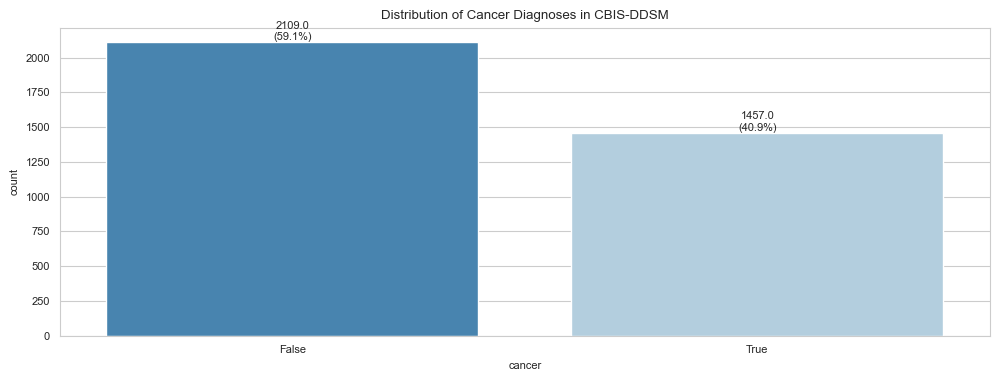

In [37]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='cancer', ax=ax, title ="Distribution of Cancer Diagnoses in CBIS-DDSM")

**Key Observations**
1. The CBIS-DDSM is well-balanced with respect to breast density, morphology, subtlety, BI-RADS assessment, and pathology. 
2. Over 40 calcification types are represented; however, the majority of cases fall into one of five types.
3. Similarly, there are nearly 20 categories for mass margins; yet, but most cases fall into one of the five major classes:
   1. Spiculated
   2. Circumscribed
   3. Obscured
   4. Ill-Defined

Next up, bivariate analysis. 